<a href="https://colab.research.google.com/github/lucaskup/TSS_ChlorophyllA_Prediction/blob/master/MDPI_Sensors_Chlorophilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Imports (RUN ME!)
#Library import
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import keras
import copy

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import PathPatch

Using TensorFlow backend.


In [0]:
#@title Select Experiment
place = "broa" #@param ["unisinos", "broa"]


In [0]:
experiment = 1 if place == "unisinos" else 0
#print(place,experiment)
if(experiment == 0):
  dataset = pd.read_excel('dados_broa.xls',sheet_name='dados_broa')
else:
  dataset = pd.read_excel('dodos_unisinos.xls',sheet_name='dodos_unisinos')
complete_set = dataset.values

###Create coordinate grid
grid_num = 2

complete_set[:,-2] = complete_set[:,-2] - min(complete_set[:,-2])
complete_set[:,-1] = complete_set[:,-1] - min(complete_set[:,-1])

complete_set[:,-2] = complete_set[:,-2] // ((max(complete_set[:,-2])+1) / grid_num)  
complete_set[:,-1] = complete_set[:,-1] // ((max(complete_set[:,-1])+1) / grid_num)


if(experiment == 0):
  #Indexes for information on the dataset
  #PH  B  G  R RE1 RE2 RE3 NIR RE4 SWIR1 SWIR2  lat  long Chloro SS 
  #1, 10 11 12  13, 14, 15, 16, 17,  18,    19,  40,   41,     4, 7 

  #jan = complete_set[:,[1,10,11,12,13,14,15,16,17,18,19,40,41,4,7]]
  #ma = complete_set[:,[2,20,21,22,23,24,25,26,27,28,29,40,41,5,8]]
  #ju = complete_set[:,[3,30,31,32,33,34,35,36,37,38,39,40,41,6,9]]
  jan = complete_set[:,[1,10,11,16,40,41,4,7]]
  jan = np.c_[ np.ones(len(jan)),jan ]   
  jan[:,0] = 0

  ma = complete_set[:,[2,20,21,26,40,41,5,8]]
  ma = np.c_[np.ones(len(ma)), ma ]   
  ma[:,0] = 1

  ju = complete_set[:,[3,30,31,36,40,41,6,9]]
  ju = np.c_[np.ones(len(ju)) , ju]   
  ju[:,0] = 2
  complete_set =  np.concatenate((jan,ma,ju),axis=0)
else:
  d2016 = complete_set[:,[1,7,8,9,13,14,3,5]]
  d2017 = complete_set[:,[2,10,11,12,13,14,4,6]]
  complete_set =  np.concatenate((d2016,d2017),axis=0)

complete_set = complete_set.astype(float)
X = complete_set[:,0:-2]
Y = complete_set[:,-2:]

In [0]:
#Data preprocessing
#onehotencoder = OneHotEncoder(categorical_features = [0,-2,-1])
#X = onehotencoder.fit_transform(X).toarray()

if(experiment == 0):
  ct = ColumnTransformer([("onehot", 
                          OneHotEncoder(categories='auto'),
                          [0])],
                        remainder = 'passthrough',
                          sparse_threshold=0)
  X = np.array(ct.fit_transform(X), dtype=np.float)

hor = len(X[0]) - 2
ct_hor = ColumnTransformer([("Horizontal", 
                            OneHotEncoder(categories='auto'),
                            [hor])],
                          remainder = 'passthrough',
                          sparse_threshold=0)
X = np.array(ct_hor.fit_transform(X), dtype=np.float)

ver = len(X[0]) - 1
ct_ver = ColumnTransformer([("Vertical",
                            OneHotEncoder(categories='auto'),
                            [ver])],
                          remainder = 'passthrough',
                          sparse_threshold=0)
X = np.array(ct_ver.fit_transform(X), dtype=np.float)


#Exclude the first bit of the dummy variables to avoid unecessary bigger feature space
if(experiment == 0):
  X = np.delete(X,3+grid_num,1)
  X = np.delete(X,3,1)
  X = np.delete(X,0,1)
else:
  X = np.delete(X,grid_num,1)
  X = np.delete(X,0,1)

mmX = MinMaxScaler()
mmY = MinMaxScaler()

X = mmX.fit_transform(X)
Y = mmY.fit_transform(Y)

In [0]:
#Parameters valid through out all the models
#Train-Test-Validation SPLIT
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)   
n_split=10
y_name = ["Chlorophill-a","TSS"]
scoring = {'r2': 'r2',
           'mse': 'neg_mean_squared_error'}
kfold_indexes = list(KFold(n_split,shuffle=True).split(x_train))
def getKfoldIndexes():
  return copy.deepcopy(kfold_indexes)

def print_cross(name,scores):
  print("______________",name,"______________")
  print("Shapiro R2",stats.shapiro(scores['test_r2']))
  print(scores['test_r2'])  
  print("R2: %0.5f (+/- %0.5f)" % (scores['test_r2'].mean(), scores['test_r2'].std() * 2.576 / np.sqrt(len(scores['test_r2']))))
  print("Shapiro MSE",stats.shapiro(scores['test_mse']))
  print(scores['test_mse'])  
  print("MSE: %0.5f (+/- %0.5f)" % (scores['test_mse'].mean(), scores['test_mse'].std() * 2.576 / np.sqrt(len(scores['test_mse']))))

def generateGraphs(estimators,pred_index):
  varia = 0
  cross_val_indexes = getKfoldIndexes()
  plt.style.use(['seaborn-ticks'])
  fig = plt.figure(figsize=(16,16))
  
  fig.subplots_adjust(hspace=0.4, wspace=0.4)
  for est in estimators:
    x_temp = cross_val_indexes[varia][1]
    ground_truth = y_train[x_temp,pred_index]
    x_temp = x_train[x_temp]
    pred = est.predict(x_temp)
    #print("R2",r2_score(ground_truth,pred))
    varia = varia + 1
    ax = fig.add_subplot(4, 3, varia)
    ax.plot(ground_truth, pred,"o")
    ax.plot([0, 1], [0, 1], 'k-')
    
    ax.set_xlabel('Ground Truth')
    ax.set_ylabel('ANN Prediction')
    ax.set_title('R2')
    
    #ax.title('R2')
    #ax.xlabel('Ground Truth')
    #ax.ylabel('ANN Prediction')
    ax.legend([y_name[pred_index]], loc='upper left')
    ax.grid()
    #_plotGraphs(pred,grd_truth,legend,varia)
  plt.show()

In [0]:
class ModelResult:
  def __init__(self,name):
    self.name = name
    self.train_results = {'mse':[],
                         'r2':[]}
    self.test_results = {'mse':None,
                         'r2':None}

modelResults = []

def registerModelResults(name, scores, mse_test, r2_rest):
  mr = ModelResult(name)
  mr.train_results['mse'] = scores['test_mse']
  mr.train_results['r2'] = scores['test_r2']


  mr.test_results['mse'] = mse_test
  mr.test_results['r2'] = r2_rest
  modelResults.append(mr)

______________ Chlorophill-a ______________
Shapiro R2 (0.9338528513908386, 0.48684006929397583)
[0.29482275 0.37061683 0.24761374 0.35435434 0.31473091 0.30380749
 0.4259385  0.44130816 0.46666954 0.30130869]
R2: 0.35212 (+/- 0.05608)
Shapiro MSE (0.9202203154563904, 0.3587961792945862)
[-0.01988941 -0.01398993 -0.01992588 -0.01579258 -0.01772785 -0.02020222
 -0.01292268 -0.01569072 -0.01233248 -0.0166265 ]
MSE: -0.01651 (+/- 0.00225)


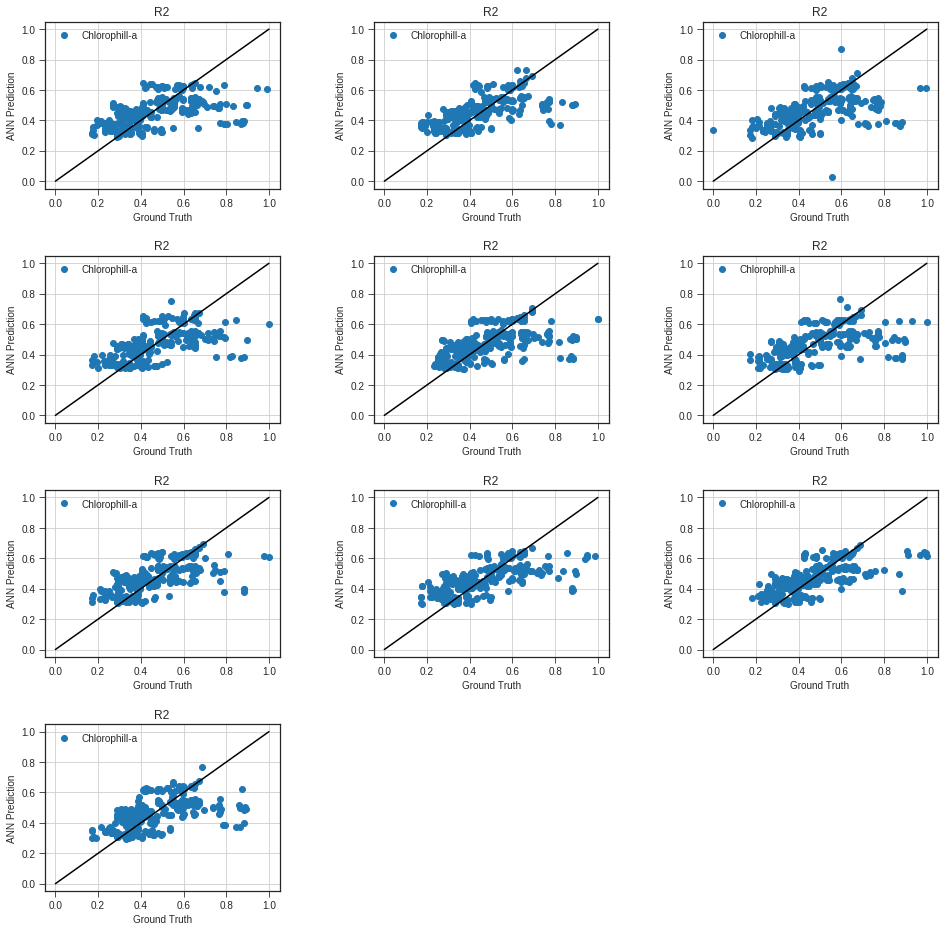

______________ TSS ______________
Shapiro R2 (0.9136679172515869, 0.307147741317749)
[0.40470068 0.3806816  0.35864202 0.35878459 0.40453062 0.39830308
 0.47850142 0.4072803  0.44203597 0.4096457 ]
R2: 0.40431 (+/- 0.02788)
Shapiro MSE (0.9409300088882446, 0.5634078979492188)
[-0.01246734 -0.0142627  -0.01399896 -0.01290666 -0.01467496 -0.01561757
 -0.01209267 -0.01129013 -0.0115606  -0.01462992]
MSE: -0.01335 (+/- 0.00115)


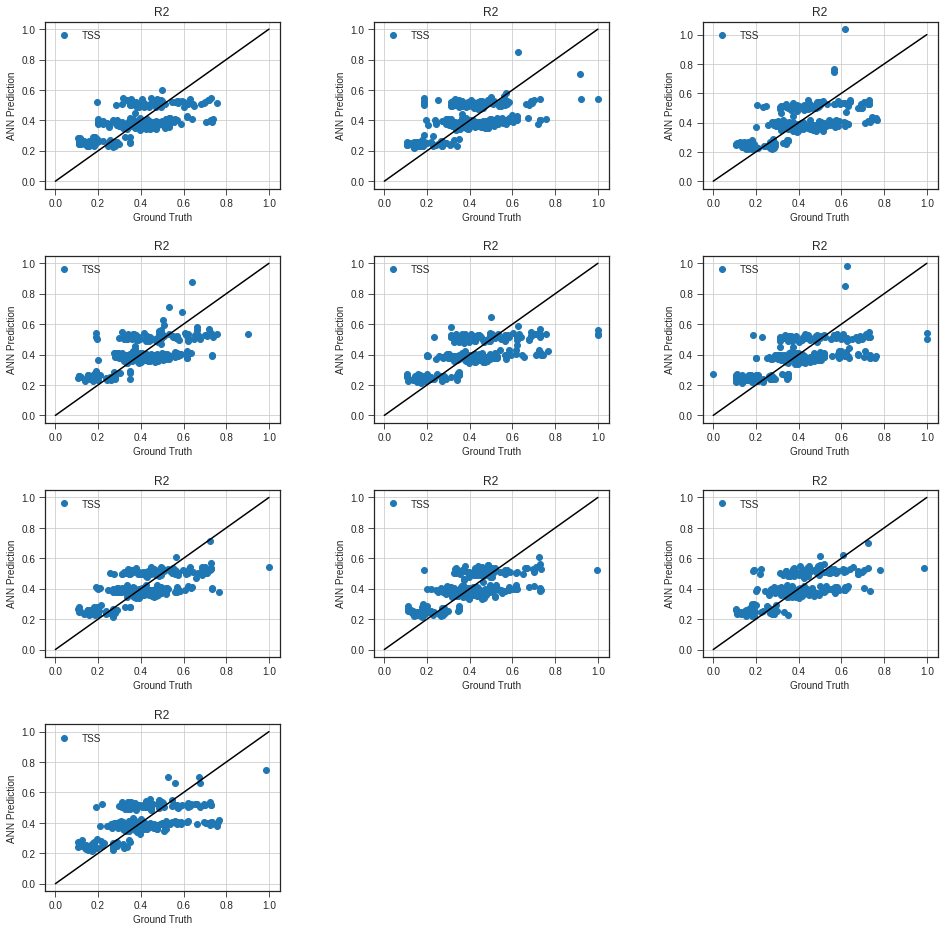

In [8]:
#Linear Regression
for i in range(2):
  linear = LinearRegression()
  scores = cross_validate(linear, x_train, y_train[:,i], cv=getKfoldIndexes(), scoring=scoring, return_estimator=True)
  print_cross(y_name[i],scores)
  generateGraphs(scores['estimator'],i)
  
  linear = LinearRegression()
  linear.fit(x_train,y_train[:,i])
  y_pred = linear.predict(x_test)

  registerModelResults('Linear:'+y_name[i],
                       scores,
                       mean_squared_error(y_test[:,i], y_pred),
                       r2_score(y_test[:,i], y_pred))


______________ Chlorophill-a ______________
Shapiro R2 (0.9061374068260193, 0.2554984986782074)
[0.29383512 0.36839484 0.25023824 0.35207727 0.30399105 0.29886597
 0.42674256 0.44551185 0.46287515 0.29670261]
R2: 0.34992 (+/- 0.05689)
Shapiro MSE (0.9249505400657654, 0.40009835362434387)
[-0.01991726 -0.01403932 -0.01985638 -0.01584828 -0.01800569 -0.02034561
 -0.01290458 -0.01557266 -0.01242022 -0.01673611]
MSE: -0.01656 (+/- 0.00226)


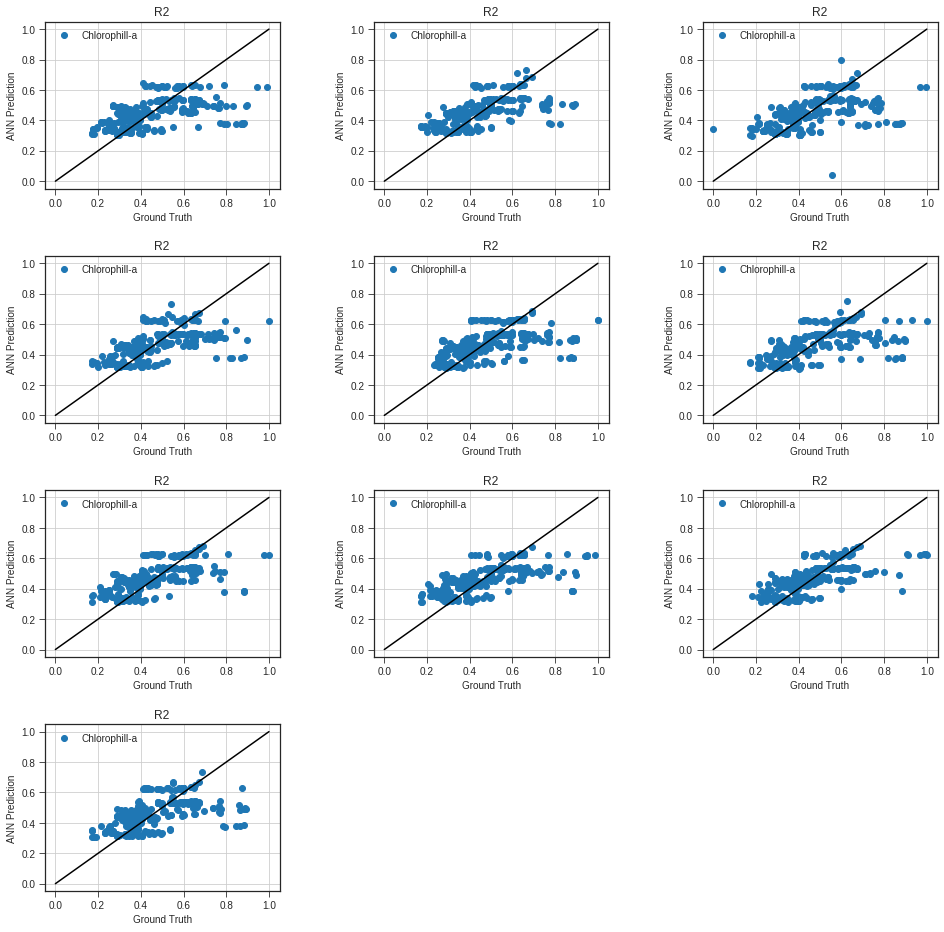

______________ TSS ______________
Shapiro R2 (0.9138410687446594, 0.3084312081336975)
[0.40607611 0.3720194  0.36191179 0.36249255 0.3934685  0.39668376
 0.47939263 0.41576503 0.43662011 0.39930928]
R2: 0.40237 (+/- 0.02771)
Shapiro MSE (0.9388464093208313, 0.5402506589889526)
[-0.01243854 -0.01446219 -0.01392759 -0.01283203 -0.01494758 -0.0156596
 -0.01207201 -0.01112852 -0.01167281 -0.01488607]
MSE: -0.01340 (+/- 0.00122)


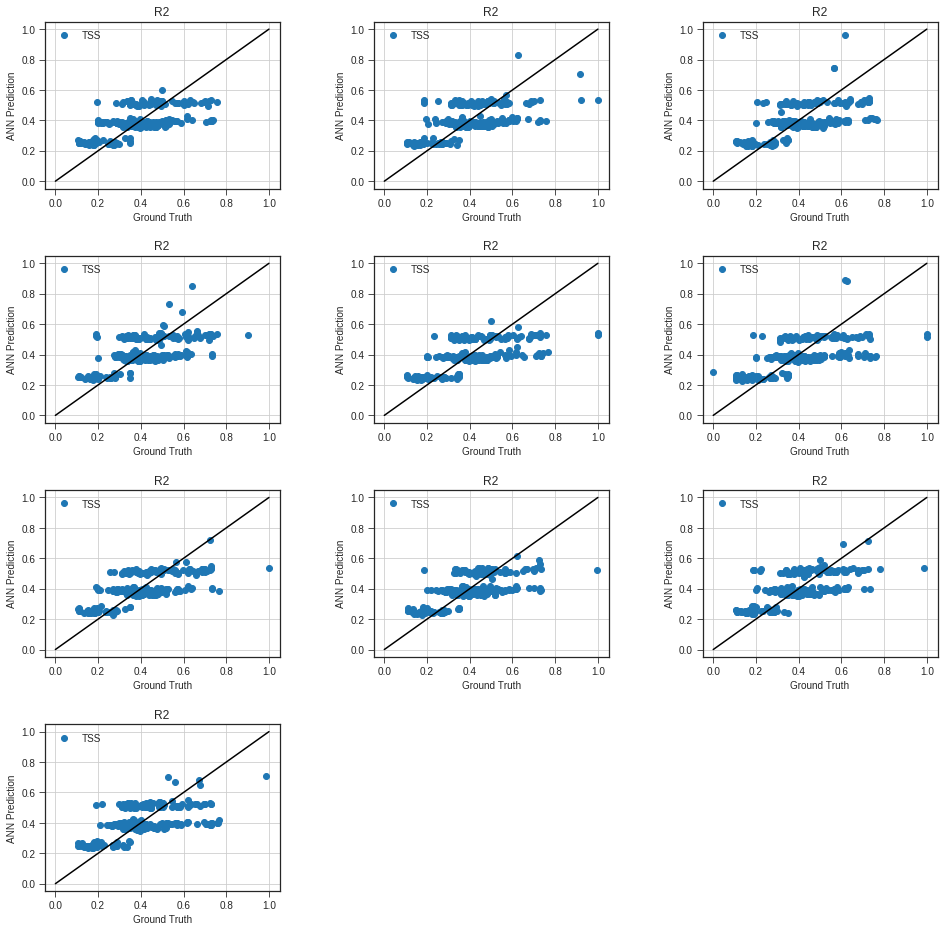

In [9]:
#LASSO
for i in range(2):
  lasso = LassoCV(cv=5)
  scores = cross_validate(lasso, x_train, y_train[:,i], cv=getKfoldIndexes(), scoring=scoring, return_estimator=True)
  print_cross(y_name[i],scores)
  generateGraphs(scores['estimator'],i)

  lasso = LassoCV(cv=5)
  lasso.fit(x_train,y_train[:,i])
  y_pred = lasso.predict(x_test)

  registerModelResults('Lasso:'+y_name[i],
                       scores,
                       mean_squared_error(y_test[:,i], y_pred),
                       r2_score(y_test[:,i], y_pred))

______________ Chlorophill-a ______________
Shapiro R2 (0.9769096970558167, 0.9465122222900391)
[0.40518209 0.367435   0.44604326 0.46631453 0.43542425 0.47997617
 0.43117535 0.49683461 0.40496436 0.41109495]
R2: 0.43444 (+/- 0.03036)
Shapiro MSE (0.9223470687866211, 0.37694716453552246)
[-0.01677674 -0.01406066 -0.01467076 -0.01305402 -0.01460553 -0.01509013
 -0.01280479 -0.01413127 -0.01375932 -0.01401396]
MSE: -0.01430 (+/- 0.00086)


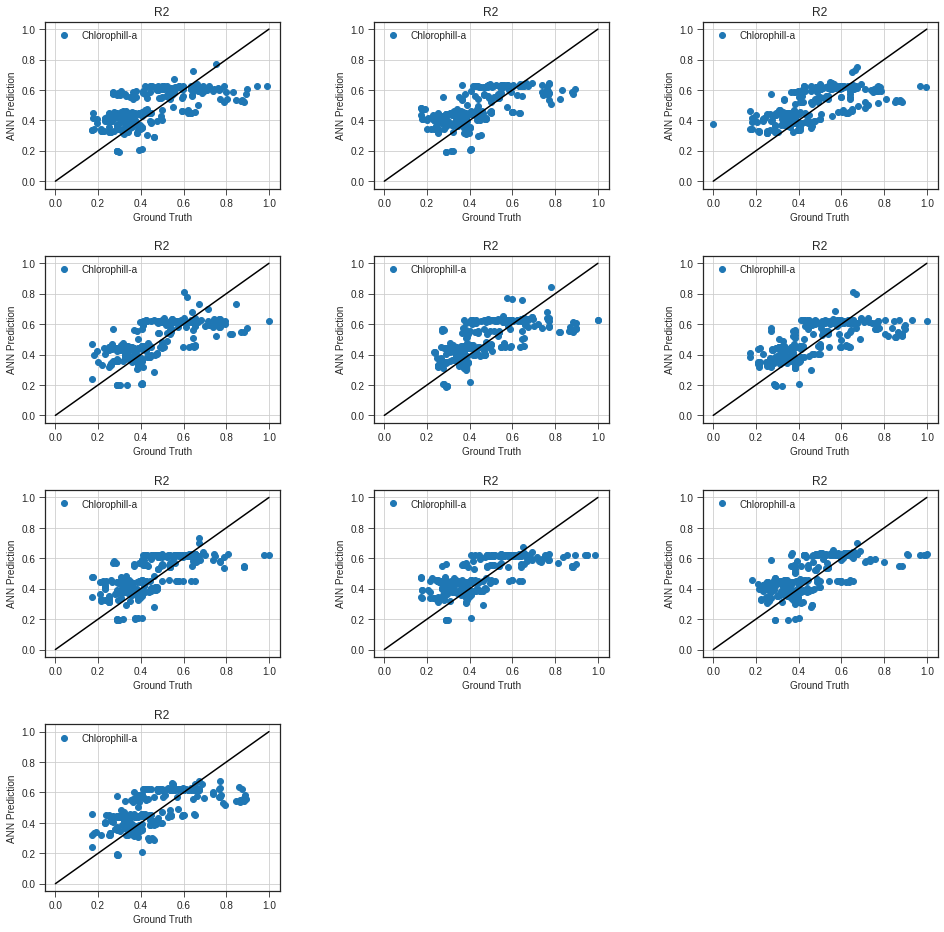

______________ TSS ______________
Shapiro R2 (0.919487714767456, 0.3527020812034607)
[0.41301406 0.45964405 0.40144809 0.46786264 0.46169407 0.49951878
 0.50273622 0.4682818  0.45091434 0.48139649]
R2: 0.46065 (+/- 0.02536)
Shapiro MSE (0.9123334884643555, 0.29740726947784424)
[-0.01229324 -0.01244422 -0.01306463 -0.01071109 -0.01326621 -0.01299043
 -0.01153071 -0.01012818 -0.01137665 -0.01285182]
MSE: -0.01207 (+/- 0.00083)


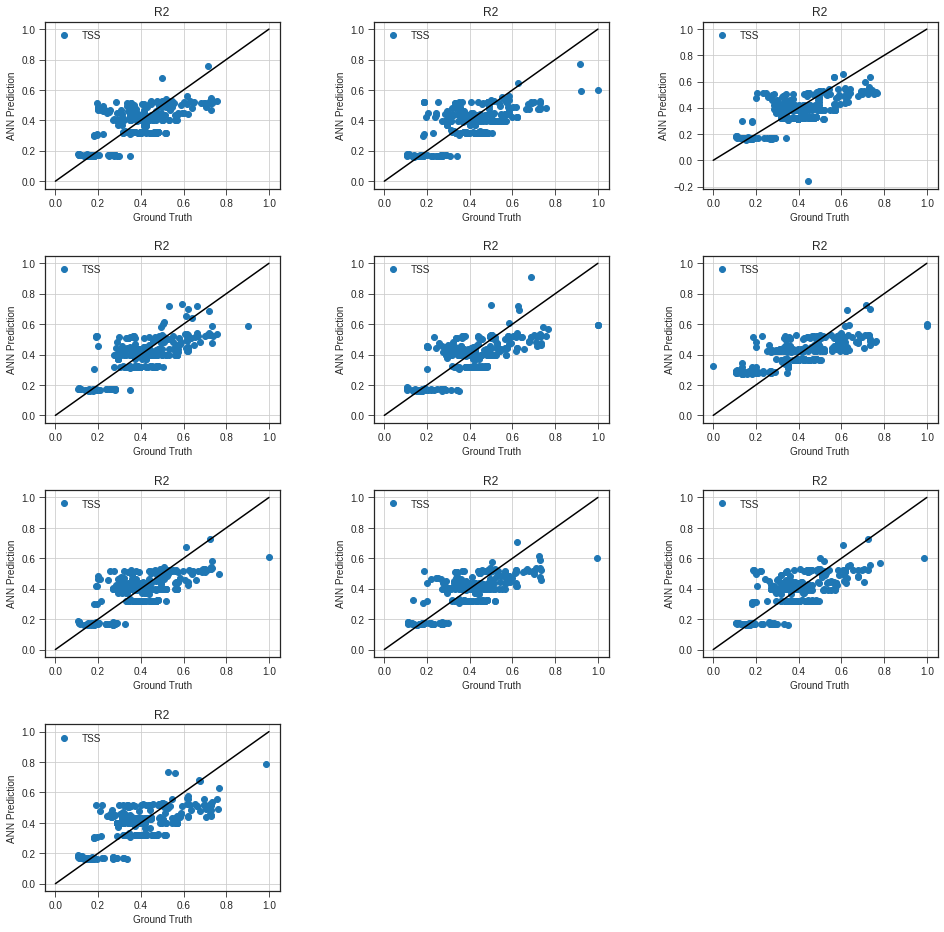

In [10]:
#SVR
for i in range(2):
  svr = SVR(gamma='scale', C=1.0, epsilon=0.2)
  scores = cross_validate(svr, x_train, y_train[:,i], cv=getKfoldIndexes(), scoring=scoring, return_estimator=True)
  print_cross(y_name[i],scores)
  generateGraphs(scores['estimator'],i)

  svr = SVR(gamma='scale', C=1.0, epsilon=0.2)
  svr.fit(x_train,y_train[:,i])
  y_pred = svr.predict(x_test)

  registerModelResults('SVR:'+y_name[i],
                       scores,
                       mean_squared_error(y_test[:,i], y_pred),
                       r2_score(y_test[:,i], y_pred))

______________ Chlorophill-a ______________
Shapiro R2 (0.9452210664749146, 0.6124252676963806)
[0.69728118 0.79669659 0.76292562 0.7453761  0.67810133 0.77562745
 0.6956281  0.78505331 0.65666863 0.72700344]
R2: 0.73204 (+/- 0.03748)
Shapiro MSE (0.9260010123252869, 0.4097295105457306)
[-0.00853813 -0.00451903 -0.00627858 -0.00622813 -0.00832749 -0.00651088
 -0.00685171 -0.00603672 -0.00793903 -0.0064964 ]
MSE: -0.00677 (+/- 0.00094)


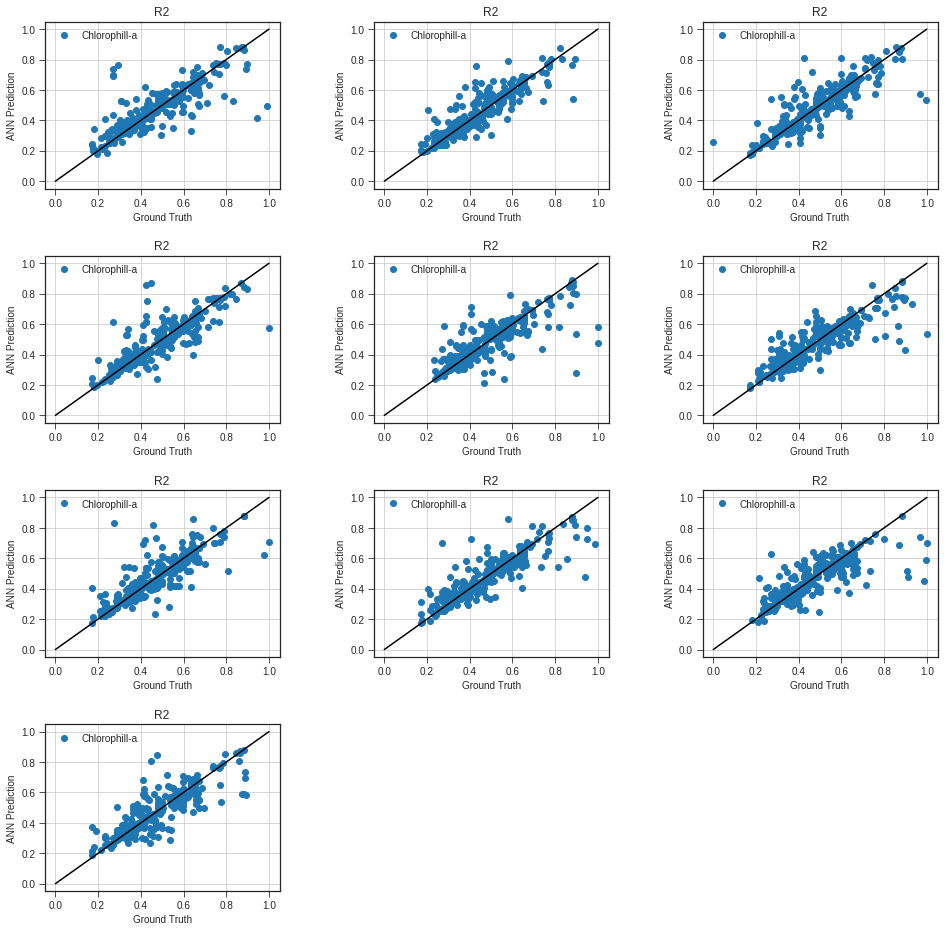

______________ TSS ______________
Shapiro R2 (0.9630478620529175, 0.8199881315231323)
[0.64287892 0.78489854 0.65814083 0.66747727 0.75877912 0.74730724
 0.72969383 0.72539827 0.70486577 0.71678001]
R2: 0.71362 (+/- 0.03546)
Shapiro MSE (0.9519014954566956, 0.6910277009010315)
[-0.00747918 -0.00495372 -0.00746178 -0.00669316 -0.00594474 -0.00655886
 -0.00626794 -0.00523062 -0.00611496 -0.00701864]
MSE: -0.00637 (+/- 0.00066)


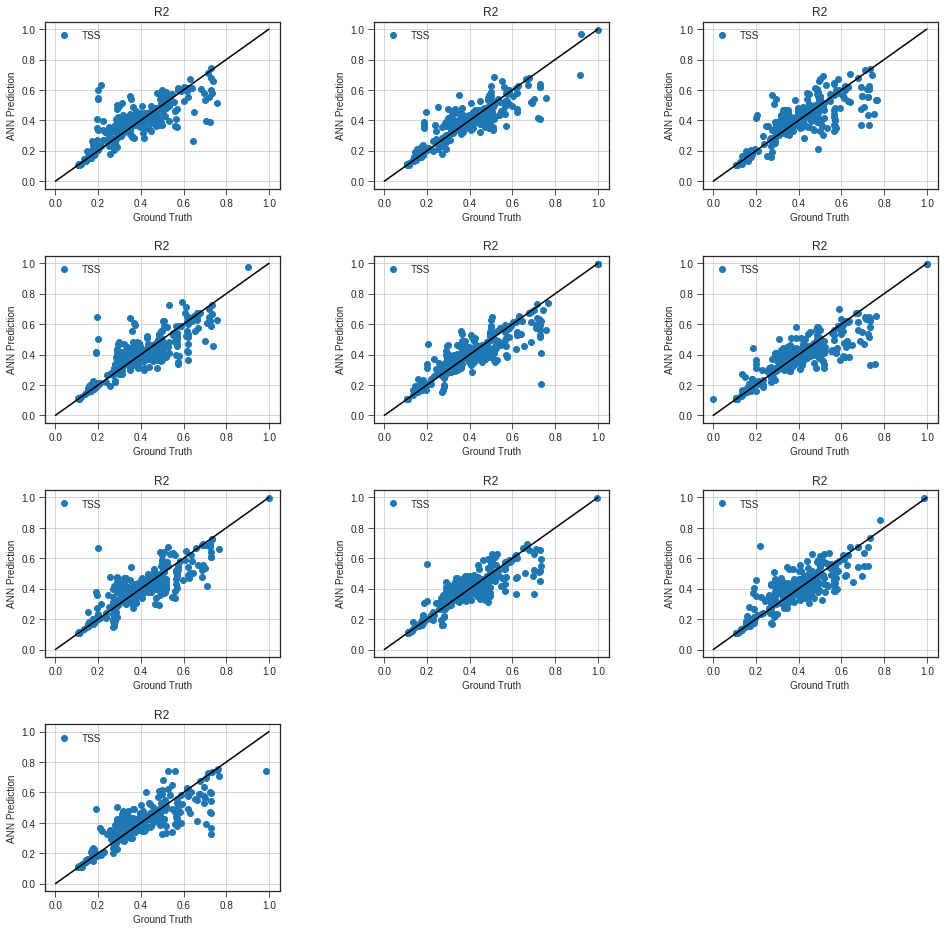

In [13]:
#KNN Regressor
for i in range(2):
  knn = KNeighborsRegressor(n_neighbors=4)
  scores = cross_validate(knn, x_train, y_train[:,i], cv=getKfoldIndexes(), scoring=scoring, return_estimator=True)
  print_cross(y_name[i],scores)
  generateGraphs(scores['estimator'],i)

  knn = KNeighborsRegressor(n_neighbors=4)
  knn.fit(x_train,y_train[:,i])
  y_pred = knn.predict(x_test)

  registerModelResults('KNN:'+y_name[i],
                       scores,
                       mean_squared_error(y_test[:,i], y_pred),
                       r2_score(y_test[:,i], y_pred))

______________ Chlorophill-a ______________
Shapiro R2 (0.8728917241096497, 0.10801751911640167)
[0.80568514 0.85465418 0.84759851 0.84987574 0.84337931 0.79659826
 0.80054605 0.83485109 0.76523183 0.71624756]
R2: 0.81147 (+/- 0.03436)
Shapiro MSE (0.9644747972488403, 0.835433304309845)
[-0.00548062 -0.00323075 -0.00403614 -0.00367206 -0.00405176 -0.00590234
 -0.0044899  -0.00463816 -0.00542867 -0.00675235]
MSE: -0.00477 (+/- 0.00085)


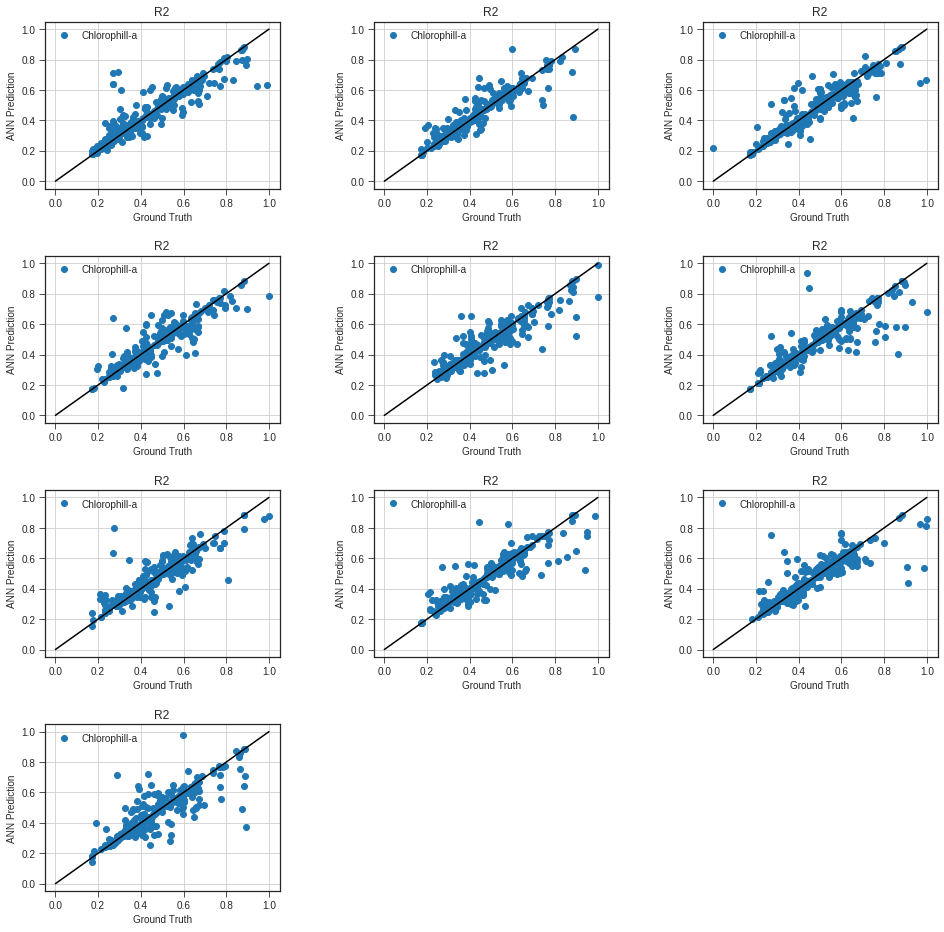

______________ TSS ______________
Shapiro R2 (0.9373480677604675, 0.5238999128341675)
[0.78871028 0.85807281 0.82983853 0.78214319 0.8471828  0.86902763
 0.80847089 0.82810115 0.81605618 0.7827143 ]
R2: 0.82103 (+/- 0.02402)
Shapiro MSE (0.8968233466148376, 0.20211578905582428)
[-0.00442504 -0.00326854 -0.00371413 -0.00438512 -0.00376608 -0.0033995
 -0.00444124 -0.00327433 -0.00381118 -0.00538468]
MSE: -0.00399 (+/- 0.00052)


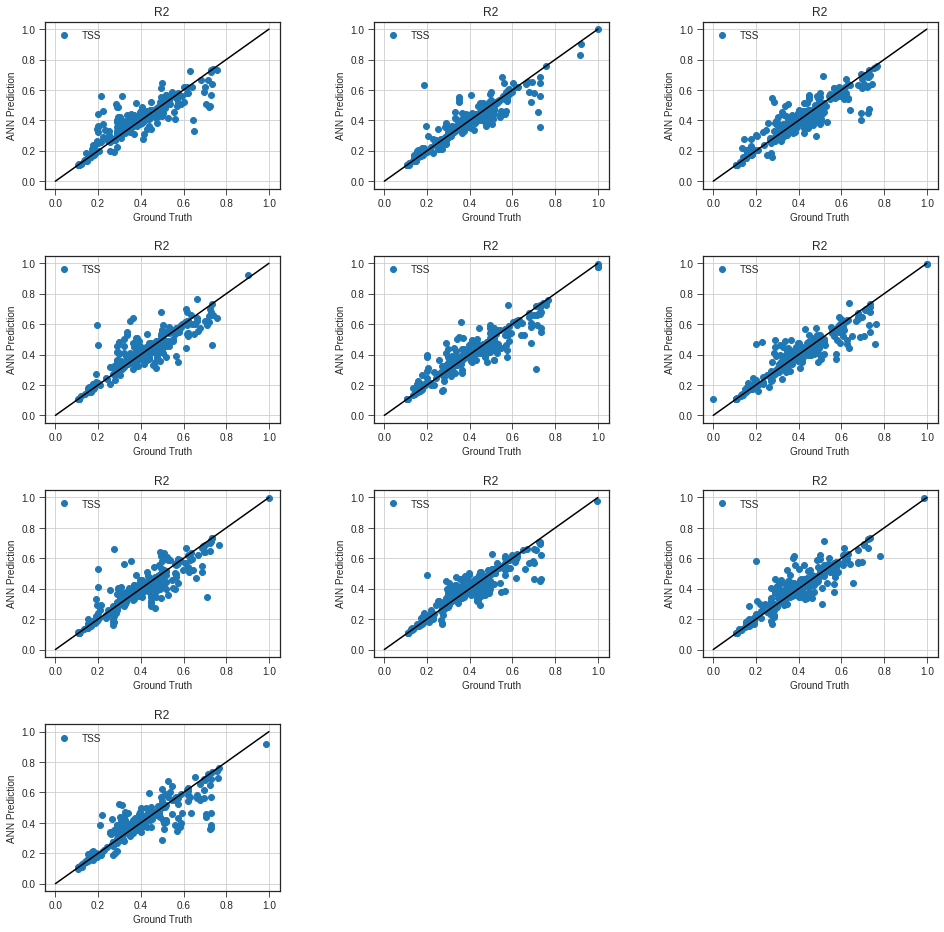

In [12]:
#Random Forest Regressor
for i in range(2):
  forest = RandomForestRegressor(n_estimators=10)
  scores = cross_validate(forest, x_train, y_train[:,i], cv=getKfoldIndexes(), scoring=scoring, return_estimator=True)
  print_cross(y_name[i],scores)
  generateGraphs(scores['estimator'],i)

  forest = RandomForestRegressor(n_estimators=10)
  forest.fit(x_train,y_train[:,i])
  y_pred = forest.predict(x_test)

  registerModelResults('RF:'+y_name[i],
                       scores,
                       mean_squared_error(y_test[:,i], y_pred),
                       r2_score(y_test[:,i], y_pred))









Epoch 1/280





 - 1s - loss: 0.0259 - mean_squared_error: 0.0259
Epoch 2/280
 - 0s - loss: 0.0151 - mean_squared_error: 0.0151
Epoch 3/280
 - 0s - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 4/280
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 5/280
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 6/280
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 7/280
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 8/280
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 9/280
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 10/280
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 11/280
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 12/280
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 13/280
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 14/280
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 15/280
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 16/280
 - 0s - loss: 0.0027 - mean_squared_er

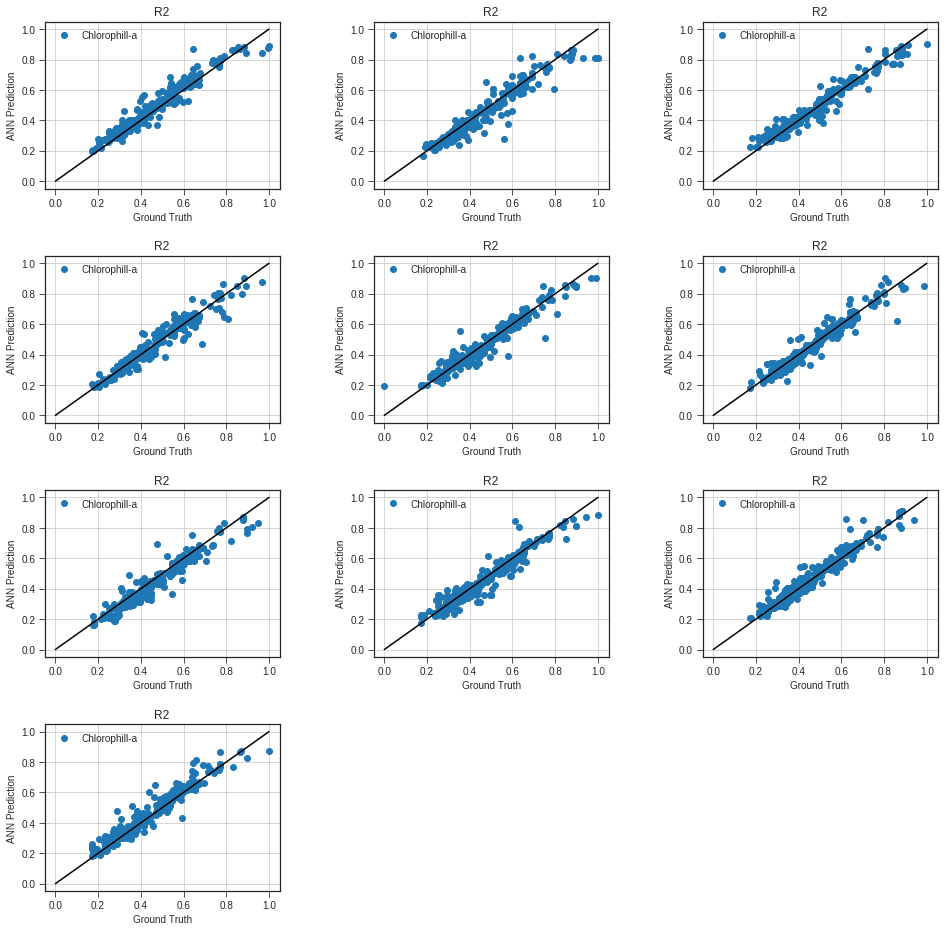

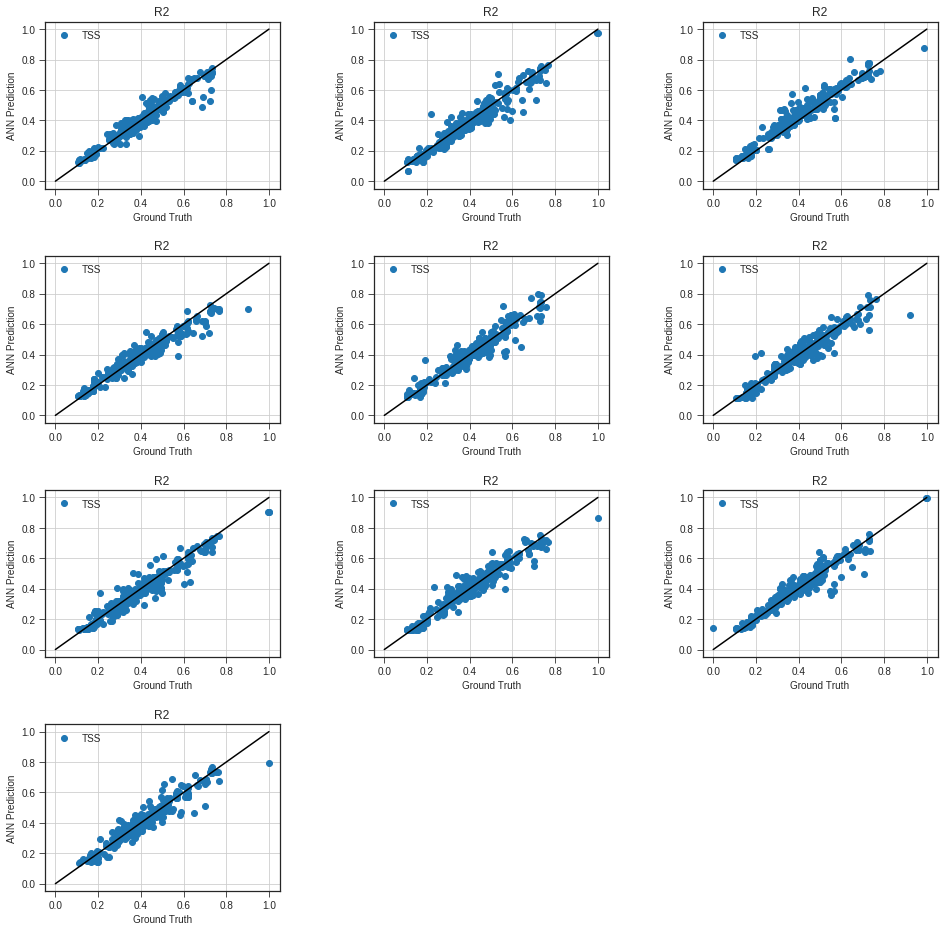

______________ Chlorophill-a ______________
Shapiro R2 (0.9676258563995361, 0.8680025935173035)
[0.88442569 0.90843391 0.91662467 0.92600003 0.8978486  0.93921825
 0.90583828 0.89842775 0.9314489  0.90508107]
R2: 0.91133 (+/- 0.01307)
Shapiro MSE (0.8811644911766052, 0.13457025587558746)
[0.00261414 0.00224399 0.00245491 0.00182276 0.0025291  0.00175577
 0.00268041 0.00270333 0.00168679 0.00220996]
MSE: 0.00227 (+/- 0.00030)
______________ TSS ______________
Shapiro R2 (0.8322373628616333, 0.03560161963105202)
[0.90051408 0.91441664 0.84942569 0.89459309 0.88858197 0.89937835
 0.88573172 0.90440586 0.91291079 0.91114405]
R2: 0.89611 (+/- 0.01477)
Shapiro MSE (0.8606246709823608, 0.07761382311582565)
[0.00214914 0.00212172 0.00352462 0.00228404 0.00267725 0.00204699
 0.00275739 0.00198853 0.00180316 0.00226127]
MSE: 0.00236 (+/- 0.00039)
Epoch 1/280
 - 1s - loss: 0.0255 - mean_squared_error: 0.0255
Epoch 2/280
 - 0s - loss: 0.0159 - mean_squared_error: 0.0159
Epoch 3/280
 - 0s - loss: 0

In [81]:
#Neural Network
from keras import backend as K

#def coeff_determination(y_true, y_pred):
#    from keras import backend as K
#    SS_res =  K.sum(K.square( y_true-y_pred ))
#    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
#    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
batch_s = 100
epoch = 280 
class ANNWrapper():
  def __init__(self,num,ann):
    self.predict = lambda x:ann.predict(x)[:,num]


def build_model():
  c = Sequential()               
  c.add(Dense(units = 8, kernel_initializer = 'normal', activation = 'sigmoid', input_dim = len(x_train[0,:])))
  c.add(Dense(units = 8, kernel_initializer = 'normal', activation = 'sigmoid'))
  c.add(Dense(units = 2, kernel_initializer = 'uniform', activation = 'sigmoid'))
  c.compile(optimizer = keras.optimizers.Adam(lr=0.090, 
                                            decay = 0.00005, 
                                            beta_1=0.9, 
                                            beta_2=0.999, 
                                            amsgrad=False),
          loss = 'mean_squared_error', 
          metrics=['mse'])
  return c

#ann = KerasRegressor(build_fn=build_model, nb_epoch=15000, batch_size=6, verbose=1)
#scores = cross_val_score(ann, x_train, y_train[:,i], cv=KFold(n_splits=n_split, shuffle=True),scoring="r2")
scores_chl = {'test_r2':[],
              'test_mse':[]}
scores_tss = {'test_r2':[],
              'test_mse':[]}
estimators_chl = []
estimators_tss = []
for train_index,test_index in KFold(n_split,shuffle=True).split(x_train):
  fold_x_train, fold_x_test = x_train[train_index],x_train[test_index]
  fold_y_train, fold_y_test = y_train[train_index],y_train[test_index]
  ann = build_model()
  ann.fit(fold_x_train, 
            fold_y_train, 
            batch_size = batch_s, #500, 
            epochs = epoch, #800, 
            verbose=2)
  estimators_chl.append(ANNWrapper(0,ann))
  estimators_tss.append(ANNWrapper(1,ann))
  fold_y_pred = ann.predict(fold_x_test)
  #y_rs = y_test   
  scores_chl['test_r2'].append(r2_score(fold_y_test[:,0], fold_y_pred[:,0]))
  scores_chl['test_mse'].append(mean_squared_error(fold_y_test[:,0], fold_y_pred[:,0]))

  scores_tss['test_r2'].append(r2_score(fold_y_test[:,1], fold_y_pred[:,1]))
  scores_tss['test_mse'].append(mean_squared_error(fold_y_test[:,1], fold_y_pred[:,1]))

scores_chl['test_r2'] = np.asarray(scores_chl['test_r2'])
scores_chl['test_mse'] = np.asarray(scores_chl['test_mse'])

generateGraphs(estimators_chl,0)


scores_tss['test_r2'] = np.asarray(scores_tss['test_r2'])
scores_tss['test_mse'] = np.asarray(scores_tss['test_mse'])

generateGraphs(estimators_tss,1)

print_cross(y_name[0],scores_chl)
print_cross(y_name[1],scores_tss)



ann = build_model()
ann.fit(x_train, 
        y_train, 
        batch_size = batch_s, 
        epochs = epoch, 
        verbose=2)

y_pred = ann.predict(x_test)

registerModelResults('ANN:Chlorophill-a',
                      scores_chl,
                      mean_squared_error(y_test[:,0], y_pred[:,0]),
                      r2_score(y_test[:,0], y_pred[:,0]))

registerModelResults('ANN:TSS',
                      scores_tss,
                      mean_squared_error(y_test[:,1], y_pred[:,1]),
                      r2_score(y_test[:,1], y_pred[:,1]))




In [82]:
for i in range(len(modelResults)):
  print(modelResults[i].name)
  print(modelResults[i].train_results)
  print(modelResults[i].test_results)

Linear:Chlorophill-a
{'mse': array([-0.01195976, -0.01386456, -0.01809974, -0.01227853, -0.01190963,
       -0.0100835 , -0.01086384, -0.01081425, -0.0123832 , -0.00924041]), 'r2': array([0.5541282 , 0.5012078 , 0.39284478, 0.49828755, 0.56594494,
       0.56368118, 0.54625445, 0.58390275, 0.49949727, 0.6084897 ])}
{'mse': 0.011659291081309224, 'r2': 0.5157665757229413}
Linear:TSS
{'mse': array([-0.00837872, -0.0097512 , -0.01060448, -0.00918359, -0.008574  ,
       -0.00817482, -0.00874029, -0.00919584, -0.00868013, -0.00864552]), 'r2': array([0.58902653, 0.58933684, 0.5687736 , 0.61769942, 0.61152964,
       0.6136265 , 0.66206844, 0.62640183, 0.59179888, 0.56190493])}
{'mse': 0.00912190238110123, 'r2': 0.5944334967461107}
Lasso:Chlorophill-a
{'mse': array([-0.01195959, -0.01399048, -0.01809325, -0.01231644, -0.01198879,
       -0.01012383, -0.0107391 , -0.01093268, -0.01246118, -0.00918922]), 'r2': array([0.55413479, 0.49667784, 0.39306254, 0.49673847, 0.56305987,
       0.56193606,

In [0]:
#@title Compile Paper Results
def adjust_box_widths(g, fac):
    posicoes = []
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                posicoes.append(xmid)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])
    return posicoes                        
                        
                        
dataframe_c = pd.concat([
    pd.DataFrame.from_dict({'place': 'Broa',
     'algorithm': 'Linear',
     'type':'Chlorophill-a',
     'mse_cross': [-0.01613805, -0.01669517, -0.01706711, -0.01723381, -0.01632928,
           -0.0155284 , -0.01585604, -0.01552434, -0.01837522, -0.01545593], 
     'r2_cross': [0.38663359, 0.34410439, 0.34486198, 0.33958817, 0.36026359,
           0.38590843, 0.36251918, 0.3111698 , 0.31584851, 0.38797224],
     'mse': 0.016403738289790908, 
     'r2': 0.3581356489615065}),
     
    pd.DataFrame.from_dict({'place': 'Broa',
     'algorithm': 'Linear',
     'type':'TSS',
     'mse_cross': [-0.01210908, -0.0160203 , -0.01508213, -0.01307713, -0.01224283,
           -0.01188389, -0.01284526, -0.01257598, -0.01418748, -0.01444566], 
     'r2_cross': [0.48059273, 0.31007627, 0.43900689, 0.45343527, 0.36963825,
           0.36863232, 0.3551185 , 0.48019482, 0.41664473, 0.29143286],
     'mse': 0.013508646512649146, 
     'r2': 0.43028484753123875}),
    
    pd.DataFrame.from_dict({'place': 'Broa',
     'algorithm': 'Lasso',
     'type':'Chlorophill-a',
     'mse_cross': [-0.0161934 , -0.0164995 , -0.01745525, -0.01722813, -0.01633297,
           -0.01568162, -0.01589395, -0.01566685, -0.01834282, -0.01556606], 
     'r2_cross': [0.38452974, 0.35179153, 0.32996305, 0.33980566, 0.36011937,
           0.37984906, 0.36099495, 0.30484673, 0.31705466, 0.38361107],
     'mse': 0.01652070560713953, 
     'r2': 0.35355881714936943}),
    
    pd.DataFrame.from_dict({'place': 'Broa',
     'algorithm': 'Lasso',
     'type':'TSS',
     'mse_cross': [-0.01238474, -0.01564442, -0.01513523, -0.01311931, -0.01229881,
           -0.01196065, -0.01277005, -0.01288038, -0.01423813, -0.0144831 ], 
     'r2_cross': [0.46876852, 0.32626367, 0.43703202, 0.45167215, 0.36675613,
           0.36455395, 0.35889442, 0.46761311, 0.4145622 , 0.28959668],
     'mse': 0.013411484535034558, 
     'r2': 0.4343825675240618}),
    
    
    pd.DataFrame.from_dict({'place': 'Broa',
     'algorithm': 'SVR',
     'type':'Chlorophill-a',
     'mse_cross': [-0.01431333, -0.0165742 , -0.01549189, -0.01520987, -0.01479948,
           -0.01464186, -0.01353667, -0.01408555, -0.01646431, -0.01397418], 
     'r2_cross': [0.45598637, 0.34885701, 0.40532845, 0.41714697, 0.42019723,
           0.42096788, 0.45576796, 0.37501057, 0.38699612, 0.44664694],
     'mse': 0.015138841607559744, 
     'r2': 0.40762998212679125}),
    
    pd.DataFrame.from_dict({'place': 'Broa',
     'algorithm': 'SVR',
     'type':'TSS',
     'mse_cross': [-0.0125735 , -0.01484886, -0.01394494, -0.01306564, -0.01173486,
           -0.01138215, -0.01182216, -0.01306394, -0.01414934, -0.01244282], 
     'r2_cross': [0.46067168, 0.36052493, 0.48130582, 0.45391542, 0.39579278,
           0.39528854, 0.40648187, 0.46002568, 0.41821317, 0.38967335],
     'mse': 0.013493957841763661, 
     'r2': 0.43090432916215204}),
    
    
    pd.DataFrame.from_dict({'place': 'Broa',
     'algorithm': 'KNN',
     'type':'Chlorophill-a',
     'mse_cross': [-0.00610976, -0.00504982, -0.00662226, -0.00606625, -0.00676096,
           -0.00704529, -0.00597095, -0.00416309, -0.00621905, -0.00671151], 
     'r2_cross': [0.76778358, 0.80161016, 0.74579786, 0.76753715, 0.73512436,
           0.72138462, 0.75994227, 0.81527947, 0.7684504 , 0.73423603],
     'mse': 0.006664547462214189, 
     'r2': 0.7392219166004583}),
    
    pd.DataFrame.from_dict({'place': 'Broa',
     'algorithm': 'KNN',
     'type':'TSS',
     'mse_cross': [-0.00587515, -0.00617306, -0.00576831, -0.00719284, -0.00528245,
           -0.00633164, -0.0057206 , -0.00655848, -0.00571878, -0.00560999], 
     'r2_cross': [0.74799131, 0.73415363, 0.78544248, 0.69937169, 0.72801599,
           0.66361256, 0.71280379, 0.7289173 , 0.76485739, 0.72482729],
     'mse': 0.006280792974391877, 
     'r2': 0.7351131422618987}),
    
    
    pd.DataFrame.from_dict({'place': 'Broa',
     'algorithm': 'RF',
     'type':'Chlorophill-a',
     'mse_cross': [-0.00414482, -0.00449531, -0.00436419, -0.00369982, -0.00374739,
           -0.00550621, -0.00511302, -0.0034622 , -0.00588741, -0.00454195], 
     'r2_cross':[0.84246592, 0.82339475, 0.83247628, 0.85822033, 0.85318744,
           0.78224946, 0.79443453, 0.84637891, 0.7807983 , 0.82014686],
     'mse': 0.00420056658070348, 
     'r2': 0.8356353963538155}),
    
    pd.DataFrame.from_dict({'place': 'Broa',
     'algorithm': 'RF',
     'type':'TSS',
     'mse_cross': [-0.00373956, -0.00383531, -0.00400254, -0.00450208, -0.00377119,
           -0.00508143, -0.00290254, -0.00392969, -0.00603654, -0.00366451], 
     'r2_cross': [0.83959537, 0.83483024, 0.85112187, 0.81183355, 0.80582812,
           0.73003379, 0.85428123, 0.83757345, 0.75179183, 0.82025399],
     'mse': 0.003602987928802658, 
     'r2': 0.8480471884967277}),
    
    
    pd.DataFrame.from_dict({'place': 'Broa',
     'algorithm': 'ANN',
     'type':'Chlorophill-a',
     'mse_cross': [0.00893079, 0.0082967 , 0.00573354, 0.00507353, 0.00855588,
           0.00745305, 0.00676045, 0.00710939, 0.00625522, 0.00579401], 
     'r2_cross':[0.67741714, 0.71517872, 0.75555176, 0.78271175, 0.66470085,
           0.71849581, 0.71658718, 0.71308459, 0.73365768, 0.77989862],
     'mse': 0.007287401665771986, 
     'r2': 0.714850160474171}),
    
    pd.DataFrame.from_dict({'place': 'Broa',
     'algorithm': 'ANN',
     'type':'TSS',
     'mse_cross': [0.00714027, 0.00642551, 0.00644422, 0.00716534, 0.00686222,
           0.00757708, 0.00776922, 0.0078461 , 0.00810137, 0.00658766], 
     'r2_cross': [0.71122914, 0.70710243, 0.66101535, 0.70237794, 0.67081879,
           0.63286409, 0.66162788, 0.68231946, 0.64168851, 0.71083423],
     'mse': 0.00673527326931398,
     'r2': 0.6829645875965857})])



############################ UNISINOS #######################################

dataframe_u = pd.concat([
    pd.DataFrame.from_dict({'place': 'Unisinos',
     'algorithm': 'Linear',
     'type':'Chlorophill-a',
     'mse_cross': [-0.01431265, -0.01482743, -0.01443296, -0.01579765, -0.01486715,
       -0.01526261, -0.01521957, -0.01446148, -0.01460805, -0.01520942], 
     'r2_cross': [0.84160121, 0.83862965, 0.84018556, 0.82832237, 0.83531828,
       0.83239324, 0.83452041, 0.8390434 , 0.83983246, 0.83688416],
     'mse': 0.014778376224397271, 
	 'r2': 0.8384811819398587}),
     
    pd.DataFrame.from_dict({'place': 'Unisinos',
     'algorithm': 'Linear',
     'type':'TSS',
     'mse_cross': [-0.02570667, -0.02613665, -0.02594324, -0.02726262, -0.02600879,
       -0.02684575, -0.02653088, -0.02679511, -0.02763756, -0.02758605], 
     'r2_cross': [0.46983983, 0.44176172, 0.46942366, 0.46315546, 0.44752382,
       0.44896146, 0.44959164, 0.44695678, 0.43829825, 0.46831834],
     'mse': 0.02679181564127699, 
     'r2': 0.45735743939648577}),
    
    pd.DataFrame.from_dict({'place': 'Unisinos',
     'algorithm': 'Lasso',
     'type':'Chlorophill-a',
     'mse_cross': [-0.01432638, -0.01483512, -0.01444581, -0.0158087 , -0.0148777 ,
       -0.01525839, -0.01519016, -0.01449585, -0.01463698, -0.01522857], 
     'r2_cross': [0.84144923, 0.83854593, 0.84004323, 0.82820225, 0.83520137,
       0.83243959, 0.83484026, 0.83866082, 0.83951525, 0.83667885],
     'mse': 0.014817980930498216, 
     'r2': 0.8380483261766873}),
    
    pd.DataFrame.from_dict({'place': 'Unisinos',
     'algorithm': 'Lasso',
     'type':'TSS',
     'mse_cross': [-0.02572993, -0.02615249, -0.02595264, -0.02727388, -0.02602768,
       -0.02684917, -0.02655411, -0.02677173, -0.02764836, -0.02755744], 
     'r2_cross': [0.46936014, 0.44142337, 0.46923138, 0.46293358, 0.4471225 ,
       0.44889115, 0.44910959, 0.44743944, 0.43807872, 0.46886979],
     'mse': 0.026767191513266776, 
     'r2': 0.45785617752065777}),
    
    
    pd.DataFrame.from_dict({'place': 'Unisinos',
     'algorithm': 'SVR',
     'type':'Chlorophill-a',
     'mse_cross': [-0.00979556, -0.00951804, -0.00975531, -0.01004814, -0.00975604,
       -0.0097412 , -0.00936688, -0.01001238, -0.00956993, -0.00978844], 
     'r2_cross': [0.89159203, 0.89641296, 0.89198059, 0.89080395, 0.89193345,
       0.89302675, 0.89815569, 0.88856199, 0.895072  , 0.89502234],
     'mse': 0.009865911029098137, 
     'r2': 0.8921714899993057}),
    
    pd.DataFrame.from_dict({'place': 'Unisinos',
     'algorithm': 'SVR',
     'type':'TSS',
     'mse_cross': [-0.02028507, -0.02039106, -0.02020991, -0.02089937, -0.0210514 ,
       -0.0201922 , -0.02043117, -0.02063231, -0.02063835, -0.02056232], 
     'r2_cross': [0.58165188, 0.56447872, 0.58667858, 0.58845802, 0.5528283 ,
       0.58553281, 0.57613594, 0.57415528, 0.58054931, 0.60369071],
     'mse': 0.019987451535322547, 
     'r2': 0.5951733161243451}),
    
    
    pd.DataFrame.from_dict({'place': 'Unisinos',
     'algorithm': 'KNN',
     'type':'Chlorophill-a',
     'mse_cross': [-0.00104076, -0.00106494, -0.00102435, -0.00093047, -0.00114268,
       -0.00095622, -0.00102888, -0.00095802, -0.00109912, -0.00100505], 
     'r2_cross': [0.98848182, 0.98841006, 0.98865744, 0.98988829, 0.98734263,
       0.98949927, 0.98881322, 0.98933724, 0.98794892, 0.98922115],
     'mse': 0.0009371018244511615, 
     'r2': 0.9897580372302691}),
    
    pd.DataFrame.from_dict({'place': 'Unisinos',
     'algorithm': 'KNN',
     'type':'TSS',
     'mse_cross': [-0.00404018, -0.00425332, -0.00405075, -0.00354712, -0.00443499,
       -0.00400225, -0.00403165, -0.00374137, -0.00446891, -0.00392025], 
     'r2_cross': [0.91667759, 0.90915573, 0.91715634, 0.9301515 , 0.90579246,
       0.91784947, 0.9163595 , 0.92277915, 0.90917457, 0.92444279],
     'mse': 0.0037727115305442576, 
     'r2': 0.9235873420165353}),
    
    pd.DataFrame.from_dict({'place': 'Unisinos',
     'algorithm': 'RF',
     'type':'Chlorophill-a',
     'mse_cross': [-0.00092896, -0.00092235, -0.00107323, -0.00074241, -0.0010681 ,
       -0.00089271, -0.0010171 , -0.00096674, -0.0010746 , -0.00073492], 
     'r2_cross': [0.9897192 , 0.98996186, 0.98811629, 0.99193202, 0.98816881,
       0.9901967 , 0.98894121, 0.98924013, 0.98821767, 0.99211824],
     'mse': 0.000927755548679232, 
     'r2': 0.9898601864375314}),
	 
    pd.DataFrame.from_dict({'place': 'Unisinos',
     'algorithm': 'RF',
     'type':'TSS',
     'mse_cross': [-0.00366714, -0.0037497 , -0.00392601, -0.00310156, -0.00410366,
       -0.00331527, -0.00383781, -0.00386067, -0.00429348, -0.00330229], 
     'r2_cross': [0.92437098, 0.91991216, 0.91970741, 0.9389254 , 0.91283046,
       0.93195051, 0.92038094, 0.92031692, 0.91273986, 0.93635315],
     'mse': 0.003657587014157358, 
     'r2': 0.9259190788124612}),
    

    pd.DataFrame.from_dict({'place': 'Unisinos',
     'algorithm': 'ANN',
     'type':'Chlorophill-a',
     'mse_cross': [0.00211533, 0.0022869 , 0.00183306, 0.00185458, 0.00232705,
       0.00200953, 0.00240204, 0.00251647, 0.00274698, 0.00200705], 
     'r2_cross': [0.97720264, 0.9754392 , 0.97984815, 0.97972482, 0.97447974,
       0.97774074, 0.97322066, 0.97227105, 0.97018537, 0.97787129],
     'mse': 0.002020404764256619, 
     'r2': 0.9778220273854747}),
    
    pd.DataFrame.from_dict({'place': 'Unisinos',
     'algorithm': 'ANN',
     'type':'TSS',
     'mse_cross': [0.00731022, 0.00719605, 0.00624533, 0.00637248, 0.00706421,
       0.00720414, 0.00830534, 0.00992894, 0.00759243, 0.00585263], 
     'r2_cross': [0.85539223, 0.86150168, 0.87524171, 0.87037638, 0.85724449,
       0.85399086, 0.82574527, 0.78830603, 0.8445358 , 0.87743475],
     'mse': 0.0063015600557503595, 
     'r2': 0.869084260475874})])

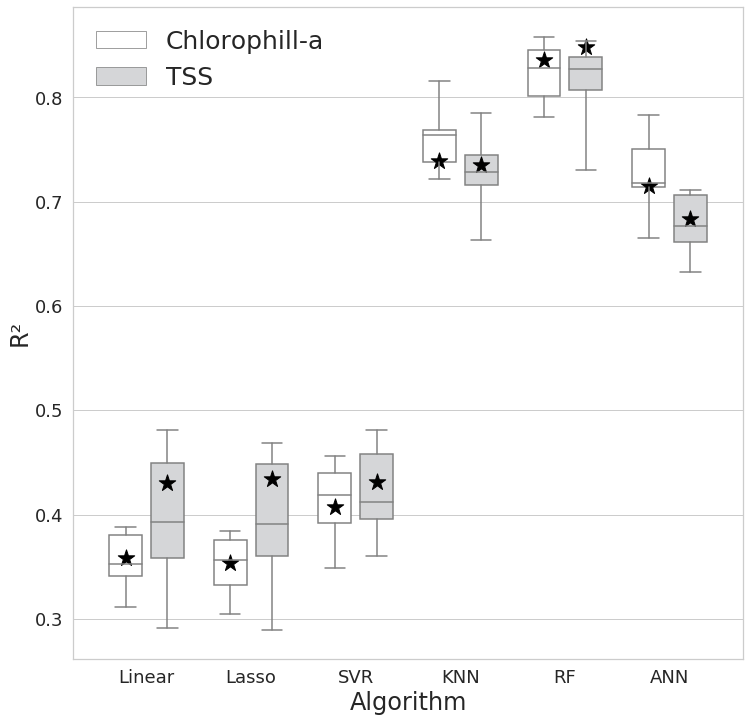

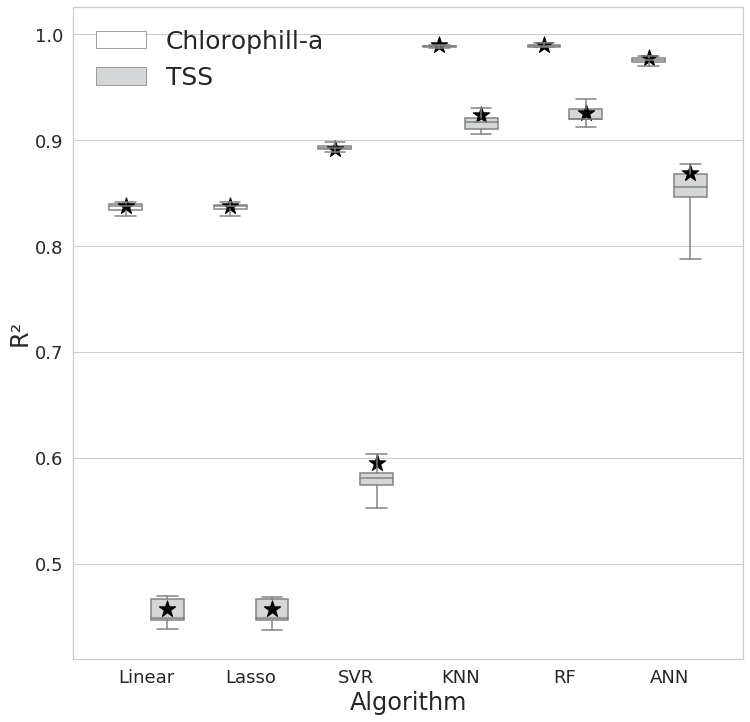

In [15]:
def boxplot_results(df):
  fig = plt.figure(figsize=(12, 12))
  sns.set(style="whitegrid")
  #plt.style.use('seaborn-bright')
  flatui = ["#ffffff", "#d4d6d9", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
  sns.set_palette(sns.color_palette(flatui))
  bp = sns.boxplot(x="algorithm", 
              y="r2_cross",
              hue = 'type',
              data=df,
              showfliers = False,
              whis='range',
              dodge=True)
  posicoes = adjust_box_widths(fig, 0.8)

  #dataframe_c.groupby(['algorithm','type']).mean()["r2"].values[[6,7,4,5,10,11,2,3,8,9,0,1]]
  #print(posicoes)
  bp.scatter(posicoes,#dataframe_c["algorithm"].values,
            df.groupby(['algorithm','type']).mean()["r2"].values[[6,7,4,5,10,11,2,3,8,9,0,1]], 
            #hue = 'type',
            marker="*", 
            c="black", 
            s=300, 
            lw=1.0)
  plt.legend(loc='upper left',fontsize=25)
  bp.tick_params(labelsize=18)
  bp.set_xlabel("Algorithm",fontsize=24)
  bp.set_ylabel("R²",fontsize=24)
  plt.show()
  plt.style.use('seaborn-bright')

boxplot_results(dataframe_c)
boxplot_results(dataframe_u)